In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
import pydotplus #pip install pydotplus

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Alcoholic_beverage_yes,Money_spent_little,Eloquence_average,Money_spent_lots,Alcoholic_beverage_no,Looks_handsome,Looks_repulsive
0,1,1,0,0,1,0,1,0
1,0,1,1,0,0,0,1,0
2,0,0,0,1,1,1,1,0
3,0,0,1,1,0,1,0,1
4,0,1,0,0,1,0,0,1
5,1,1,0,0,1,0,0,1
6,0,1,0,1,1,0,1,0


In [31]:
y

0    0
1    1
2    0
3    1
4    1
5    0
6    0
Name: Will_go, dtype: int64

In [7]:
df_test

,Eloquence_high,Alcoholic_beverage_yes,Money_spent_little,Eloquence_average,Money_spent_lots,Alcoholic_beverage_no,Looks_handsome,Looks_repulsive
0,0,0,0,1,1,1,1,0
1,1,1,1,0,0,0,1,0
2,0,1,0,1,1,0,0,1


In [16]:
features_set = set(df_train.columns) - {"Will_go"}
df_train.columns

Index(['Eloquence_high', 'Alcoholic_beverage_yes', 'Money_spent_little',
       'Eloquence_average', 'Money_spent_lots', 'Alcoholic_beverage_no',
       'Looks_handsome', 'Looks_repulsive'],
      dtype='object')

In [36]:
#1. What is the entropy  S0  of the initial system? By system states, 
#we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

P_p = 3 / 7
P_m = 1 - P_p
S_0 = -P_p*math.log2(P_p) - P_m*math.log2(P_m)
S_0

0.9852281360342515

In [46]:
#2. Let's split the data by the feature "Looks_handsome". 
#What is the entropy  S1  of the left group - the one with "Looks_handsome". 
#What is the entropy  S2  in the opposite group? 
#What is the information gain (IG) if we consider such a split?

"""
Looks_handsome=True <-> ids: 0, 1, 2, 6 
                        labels: 0, 1, 0, 0
Looks_handsome=False <-> ids: 3, 4, 5 
                        labels: 1, 1, 0                       
"""
t_part = 4 / 7
P_p_t = 1 / 4
P_m_t = 1 - P_p_t
S_t = -P_p_t*math.log2(P_p_t) - P_m_t*math.log2(P_m_t)
print(f"The entropy S1 of the left group: {S_t}")

f_part = 3 / 7
P_p_f = 2 / 3
P_m_f = 1 - P_p_f
S_f = -P_p_f*math.log2(P_p_f) - P_m_f*math.log2(P_m_f)
print(f"The entropy S2 of the right group: {S_f}")

IG = S_0 - t_part*S_t - f_part*S_f
print(f"The information gain for such a split: {IG}") 

The entropy S1 of the left group: 0.8112781244591328
The entropy S2 of the right group: 0.9182958340544896
The information gain for such a split: 0.12808527889139443


In [27]:
#Train a decision tree using sklearn on the training data. 
#You may choose any depth for the tree.

features_set = set(df_train.columns) - {"Will_go"}

will_go_tree = DecisionTreeClassifier(random_state=17, criterion="entropy")
will_go_tree.fit(df_train[features_set].values.reshape(-1, len(features_set)), y.values);

In [28]:
#Additional: display the resulting tree using graphviz. 
#You can use pydot or web-service dot2png.

import pydotplus  # pip install pydotplus
from sklearn.tree import export_graphviz


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    """
    This requires GraphViz to be installed.  
    """
    
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [29]:
tree_graph_to_png(
    tree=will_go_tree,
    feature_names=list(features_set),
    png_file_to_save="/content/pngs/topic3_decision_tree1.png",
)

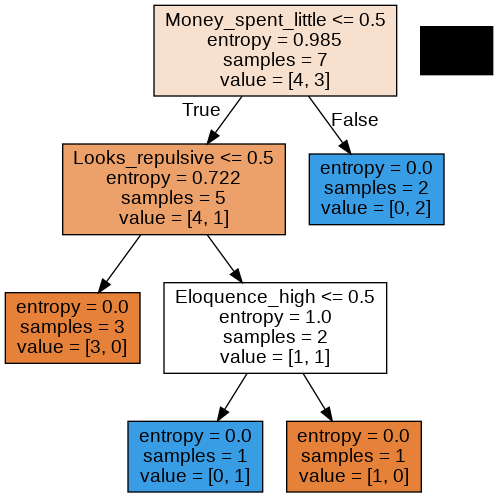

In [30]:
from IPython.display import Image
Image('/content/pngs/topic3_decision_tree1.png')

Part 2. Functions for calculating entropy and information gain.

In [47]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

In [51]:
def entropy(a_list):
    set_of_items = set(a_list)
    list_of_P = []
    for item in set_of_items:
        P_item = len([element for element in a_list if element == item]) / len(a_list)
        list_of_P.append(P_item)
    S = 0
    for P_i in list_of_P:
        S_i = -P_i*math.log2(P_i)
        S += S_i
    return S

In [52]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


In [54]:
#3. What is the entropy of the state given by the list balls_left?

print(entropy(balls_left)) # 8 blue и 5 yellow

0.9612366047228759


In [55]:
#4. What is the entropy of a fair dice? 
#(where we look at a dice as a system with 6 equally probable states)?

print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

2.584962500721156


In [57]:
# information gain calculation
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
    
    # you code here
    S_root = entropy(root)
    S_left = entropy(left)
    S_right = entropy(right)

    left_part_fract = len(left) / len(root)
    right_part_fract = len(right) / len(root)

    IG = S_root - left_part_fract*S_left - right_part_fract*S_right
    return IG

In [58]:
#5. What is the information gain from splitting the initial 
#dataset into balls_left and balls_right ?

information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [64]:
def best_feature_to_split(X, y):
    '''Outputs information gain when splitting on best feature
       !!!only for binary features'''
    
    # you code here
    IG_max = 0
    feature_IG_max = ""
    slice_idx = 0

    labels = list(y)
    set_of_features = set(X.columns)

    for feature in set_of_features:     
        for i in range(len(y)):
            left = labels[:i]
            right = labels[i:]
            IG = information_gain(features, left, right)
            if IG > IG_max:
                IG_max = IG
                feature_IG_max = feature
                slice_idx = i
    return IG_max, feature_IG_max, slice_idx

In [65]:
best_feature_to_split(df_train, y)

(0.7863117569316642, 'Eloquence_high', 5)

Part 3. The "Adult" dataset

In [112]:
data = pd.read_csv('/content/adult.data.csv')
split_idx = round(len(data) * 0.85)

In [113]:
data_train = data.iloc[:split_idx, :]
data_test = data.iloc[split_idx:, :]

In [114]:
data_train.loc[data_train["salary"] == "<=50K", "salary"] = 0
data_train.loc[data_train["salary"] == ">50K", "salary"] = 1

data_test.loc[data_test["salary"] == "<=50K", "salary"] = 0
data_test.loc[data_test["salary"] == ">50K", "salary"] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [115]:
data_train['salary'].value_counts()

0    21042
1     6635
Name: salary, dtype: int64

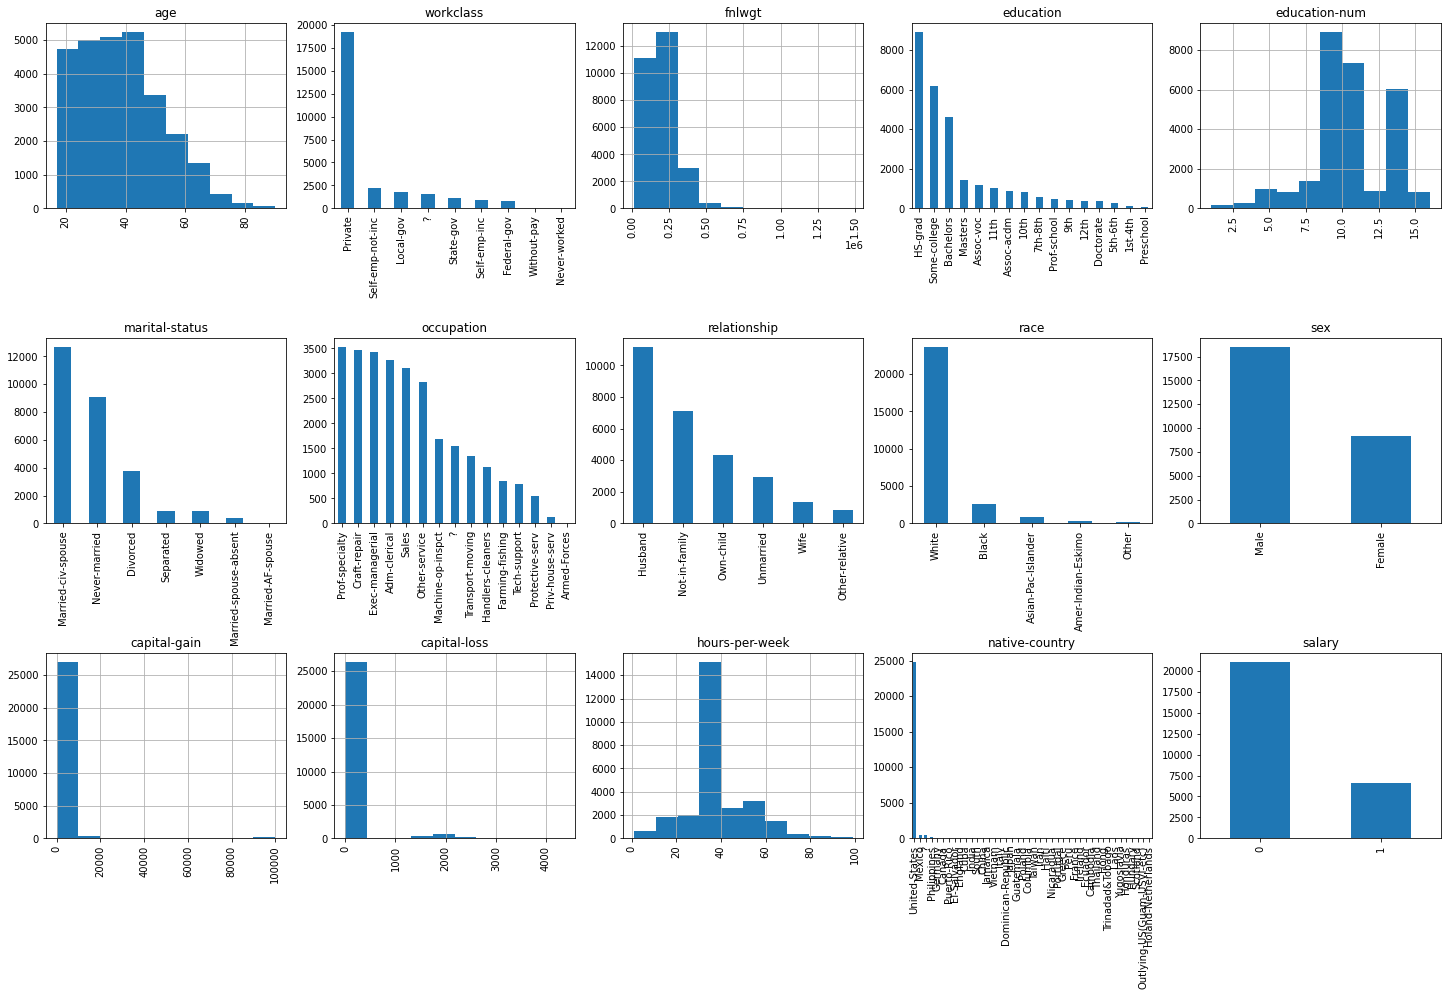

In [116]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [117]:
data_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [118]:
data_test.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [119]:
data_train['salary'] = data_train['salary'].astype(int)
data_test['salary'] = data_test['salary'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27677 entries, 0 to 27676
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27677 non-null  int64 
 1   workclass       27677 non-null  object
 2   fnlwgt          27677 non-null  int64 
 3   education       27677 non-null  object
 4   education-num   27677 non-null  int64 
 5   marital-status  27677 non-null  object
 6   occupation      27677 non-null  object
 7   relationship    27677 non-null  object
 8   race            27677 non-null  object
 9   sex             27677 non-null  object
 10  capital-gain    27677 non-null  int64 
 11  capital-loss    27677 non-null  int64 
 12  hours-per-week  27677 non-null  int64 
 13  native-country  27677 non-null  object
 14  salary          27677 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.2+ MB


In [121]:
categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

In [122]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [123]:
set(data_train.columns) - set(data_test.columns)

{'native-country_Holand-Netherlands'}

In [124]:
data_train.shape, data_test.shape

((27677, 109), (4884, 108))

In [125]:
data_test['native-country_Holand-Netherlands'] = 0

In [126]:
set(data_train.columns) - set(data_test.columns)

set()

In [127]:
X_train = data_train.drop(['salary'], axis=1)
y_train = data_train['salary']

X_test = data_test.drop(['salary'], axis=1)
y_test = data_test['salary']

In [128]:
tree = DecisionTreeClassifier(random_state=17, criterion="entropy", max_depth=3)
tree.fit(X_train.values, y_train.values);

In [129]:
tree_predictions = tree.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [132]:
accuracy_score(tree_predictions, y_test)

0.8439803439803439

In [135]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True) # you code here                     
locally_best_tree.fit(X_train, y_train); # you code here 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [138]:
locally_best_tree.best_params_

{'max_depth': 9}

In [139]:
tuned_tree = DecisionTreeClassifier(random_state=17, criterion="entropy", max_depth=9)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(tuned_tree_predictions, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.8576986076986077

In [140]:
rf = RandomForestClassifier(random_state=17, criterion="entropy")
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=17)

In [141]:
rf_predictions = rf.predict(X_test)
accuracy_score(rf_predictions, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.8579033579033579